In [106]:
import os
import shutil
import pathlib

import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=FutureWarning)

random_seed = 0
cmap_ref = 'nipy_spectral'

In [2]:
json_path = pathlib.Path('data', 'yelp_photos', 'photos.json')
data_photos = pd.read_json(json_path, lines=True)
data_photos.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

In [3]:
data_photos.describe().T

count  unique                     top    freq
photo_id     200100  200098  _CYoxbCIKuAwpq4crHCPWg       2
business_id  200100   36680  FEXhWNCMkv22qG04E83Qjg     528
caption      200100   76413                          103366
label        200100       5                    food  108152

In [4]:
data_photos.label.unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

>#### On a donc 5 catégories pour lesquelles il va falloir récupèrer de 100 à 200 images

# 1. Préparation du jeu de données de travail

## 1.1 Sélection des images pour chaque catégorie

In [5]:
sample_size = 200
data_photos_selection = pd.DataFrame()
for label in data_photos.label.unique():
    print(label)
    data_photos_selection = pd.concat([data_photos_selection, data_photos[data_photos.label == label].sample(sample_size, random_state=random_seed)], axis=0)

inside
outside
drink
food
menu


In [6]:
display(data_photos_selection.head(2), data_photos_selection.shape)

photo_id             business_id  \
26366  4bCgKE0Itp0T8wQXpYsypg  B0TP0GVKZKAi05p-sTjc6w   
88249  RN1AVvw1HXLceaNJkI0GdQ  zNBtF87cr_uzqloqWdO34g   

                           caption   label  
26366  Kerry Courtney (11.16.2018)  inside  
88249                     entrance  inside

(1000, 4)

In [7]:
data_photos_selection.label.value_counts()

inside     200
outside    200
drink      200
food       200
menu       200
Name: label, dtype: int64

In [8]:
data_photos_selection.describe().T

count unique                     top freq
photo_id     1000   1000  4bCgKE0Itp0T8wQXpYsypg    1
business_id  1000    943  pAFtOcz710oLQ-e_J6AIzw    4
caption      1000    436                          529
label        1000      5                  inside  200

## 1.2 Transfère des images sélectionnées

In [9]:
src_path = pathlib.Path('data', 'yelp_photos', 'photos')
new_path = pathlib.Path('data', 'photos')

#### On supprime un éventuel ancien dossier contenant les images

In [10]:
if os.path.exists(new_path):
    for file in  os.listdir(new_path):
        os.remove(pathlib.Path(new_path, file))
    os.rmdir(new_path)

#### On crée un dossier pour stocker les images sélectionnées et on y copie les images

In [11]:
os.mkdir(new_path)

In [12]:
for photo_name in data_photos_selection.photo_id:
    src = pathlib.Path(src_path, f"{photo_name}.jpg")
    dst = pathlib.Path(new_path, f"{photo_name}.jpg")
    shutil.copyfile(src, dst)
print("Copie des images sélectionnée terminé")

Copie des images sélectionnée terminé


## 1.3 Pré-traitement des images sélectionnées

#### On supprime un éventuel ancien dossier contenant les images pré-traitées

In [13]:
preprocessed_path = pathlib.Path('data', 'photos_preprocessed')

In [14]:
if os.path.exists(preprocessed_path):
    for file in  os.listdir(preprocessed_path):
        os.remove(pathlib.Path(preprocessed_path, file))
    os.rmdir(preprocessed_path)

#### On pré-traite les images, on crée un nouveau dossier pour les stocker et on les y copie

In [15]:
os.mkdir(preprocessed_path)

data/photos/9gsifzRIZWZEQ_slmUSnIA.jpg OUTSIDE


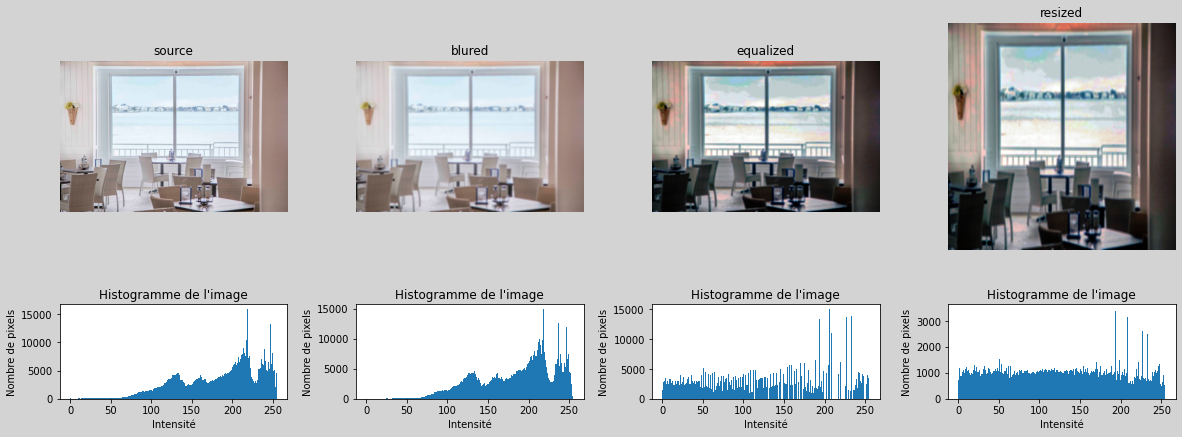

data/photos/RJufWmPFiAgKCKhf3jB-Pg.jpg DRINK


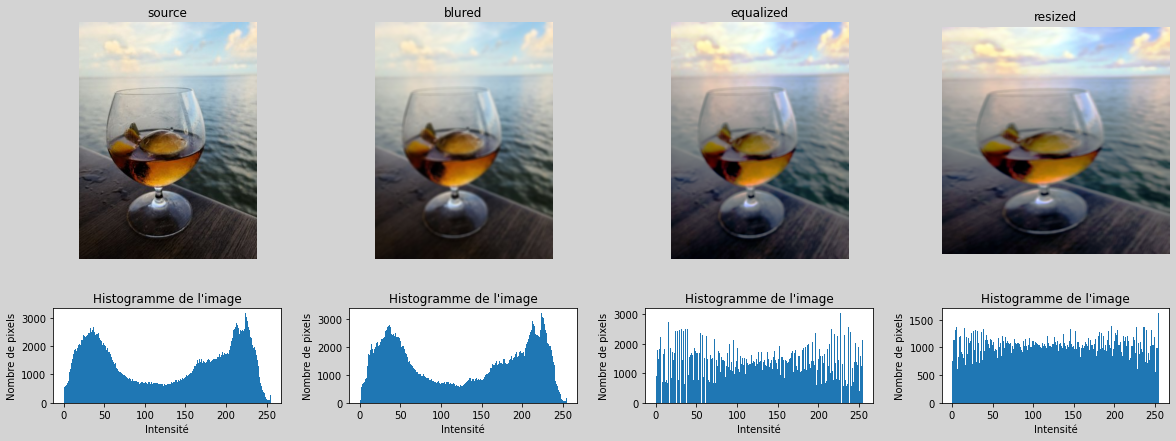

data/photos/MLILQeZOmN1klgyagfRE-A.jpg FOOD


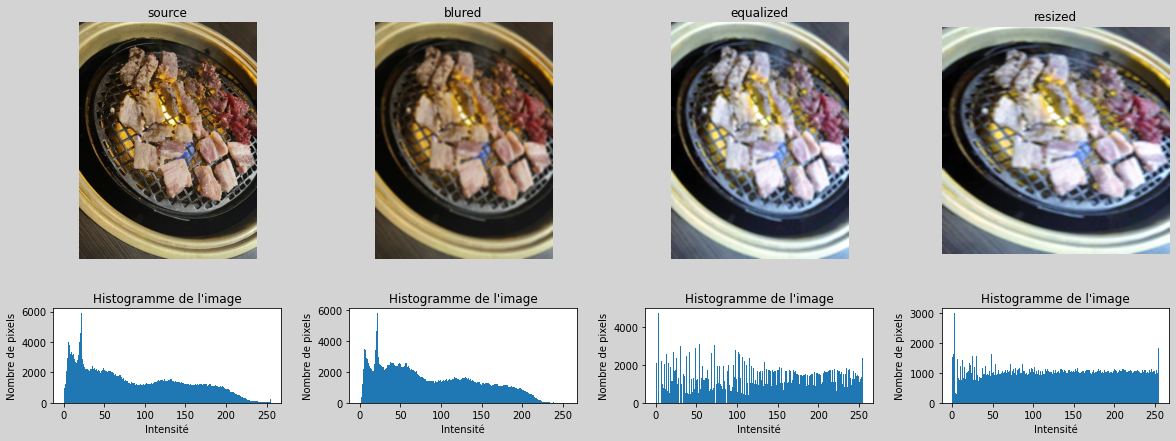

data/photos/k6x2IdfUX-Xphs2XEMz2uw.jpg MENU


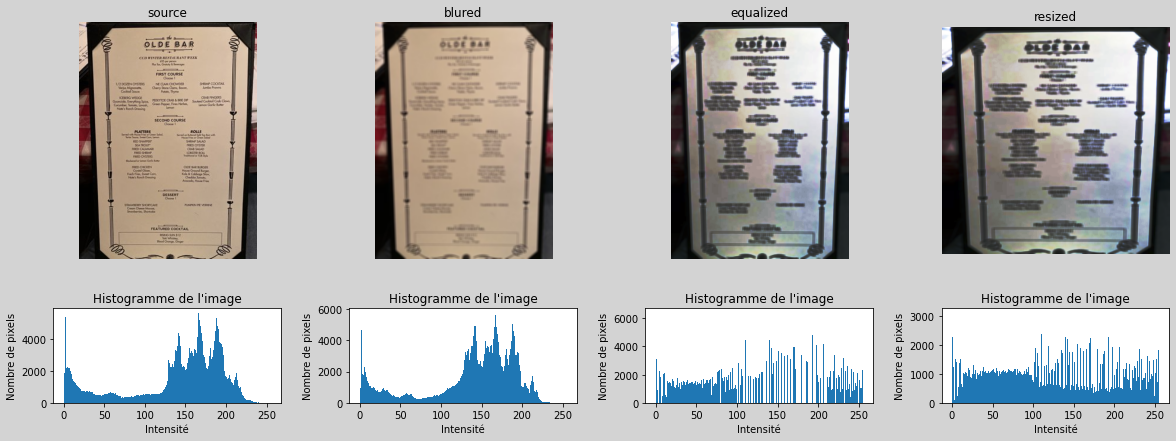

data/photos/0XrINgVTH3LtnhB5N9g-eA.jpg MENU


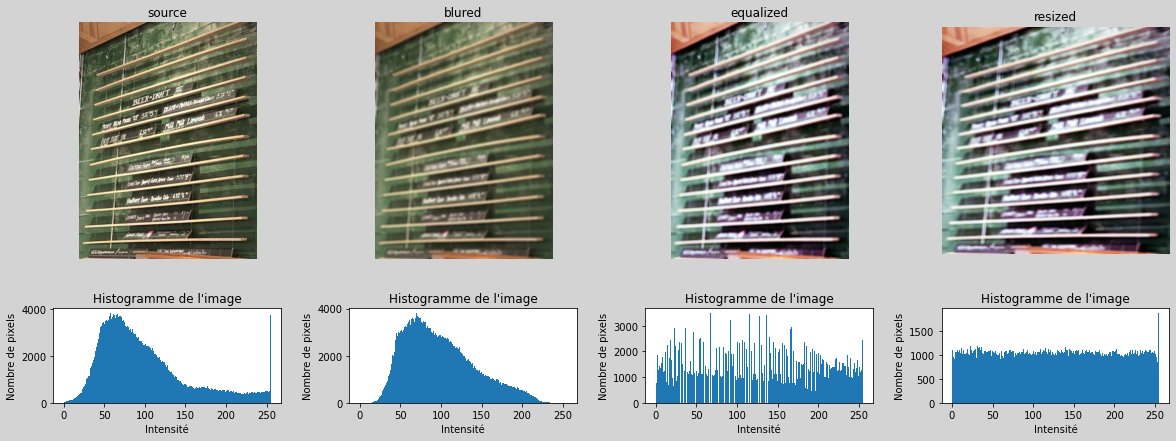

In [16]:
sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
param_blur = 2
newsize = (300, 300)

for i, photo in data_photos_selection.iterrows():
    img_path = pathlib.Path(new_path, f"{photo.photo_id}.jpg")
    img = Image.open(img_path)
    
    # Gray
    # gray_img = ImageOps.grayscale(img)
    
    # Blur
    # blured_img = gray_img.filter(ImageFilter.BoxBlur(param_blur))
    blured_img = img.filter(ImageFilter.BoxBlur(param_blur))
    
    # Equalize
    equalized_img = ImageOps.equalize(blured_img)
    
    # Resize
    final_img = equalized_img.resize(newsize)
    
    # Save image
    export_path = pathlib.Path(preprocessed_path, f"{photo.photo_id}.jpg")
    final_img.save(export_path)

    if photo.photo_id in sample_id_show:
        print(img_path, photo.label.upper())
        fig = plt.figure(figsize=(20,7), facecolor='lightgray')
        
        #steps_show=[img, gray_img, blured_img, equalized_img, final_img]
        steps_show=[img, blured_img, equalized_img, final_img]
        steps_name=["source", "blured", "equalized", "resized"]
        
        spec = gridspec.GridSpec(
                        ncols=len(steps_show), nrows=2,
                        width_ratios=[1]*len(steps_show), wspace=0.3,
                        hspace=0.3, height_ratios=[5, 2]
                        )
        
        for i, image in enumerate(steps_show):

            fig.add_subplot(spec[i])
            plt.title(steps_name[i])
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)
            plt.axis('off')

            fig.add_subplot(spec[i+len(steps_show)])
            mat = np.array(image)
            plt.title("Histogramme de l'image")
            plt.hist(mat.flatten(), bins=range(256))
            plt.xlabel('Intensité')
            plt.ylabel('Nombre de pixels')

        plt.show()

L'**histogramme** d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité. <br>Pour une image en noir et blanc, il indique en abscisse le niveau de gris (entier entre 0 et 255) et en ordonnée, le nombre de pixels ayant cette valeur.

Lorsque l'histogramme est **normalisé**, il indique en ordonnée la probabilité pi de trouver un pixel de niveau de gris i dans l'image. (ce n'est pas le cas ci-dessus)

Un **histogramme cumulé normalisé** calcule le pourcentage de pixels ayant une valeur inférieure à un niveau de gris donné. (ce n'est pas le cas ci-dessus)

# 2. Création *manuelle* des `bag of visual-words`
<img src="medias/bovw_process.jpeg" width="400">

## 2.1 Extraction de features et calcul des descripteurs des images avec SIFT, SURF, BRIEF ou ORB

La première étape pour construire un `bag of visual words` est d'effectuer une extraction des features et de calculer les descripteurs pour chaque image du jeu de données. Un descripteur est un vecteur qui décrit le voisinage de la feature à laquelle il est associé. Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images. Pour faciliter cette étape de matching *(le k-means plus bas par exemple)*, le descripteur doit présenter de nombreuses propriétés d'invariance (rotation, échelle, illumination et dans une certaine mesure les variations affines). Ainsi, les descripteurs de deux features identiques à un changement géométrique ou photométrique près doivent donc être aussi proches que possible. L'étape de matching revient alors à comparer les descripteurs.

L'un des algorithmes les plus connus est `SIFT` *(Scale Invariant Feature Transform)*, mais il est existe d'autres comme `SURF` *(Spped Up Robust Feature)*, `BRIEF` *(Binary Robust Independent Elementary Features)* ou `ORB` *(ORiented BRIEF)*.
Ces algorithmes convertissent chaque patch en un vecteur à *n* dimensions et donc après cette étape, chaque image est une collection de vecteurs de la même dimension (128 pour SIFT), où l'ordre des différents vecteurs n'a pas d'importance.

<img src="medias/bovw_extract_features.png" width="400">

In [ ]:
max_features = 250

# Initialize the ORB / SIFT detector algorithm
orb = cv2.ORB_create(nfeatures=max_features, patchSize=15)
sift = cv2.SIFT_create(nfeatures=max_features) # patchSize is fixed in code (size=12σ×12σ)

data/photos_preprocessed/9gsifzRIZWZEQ_slmUSnIA.jpg OUTSIDE


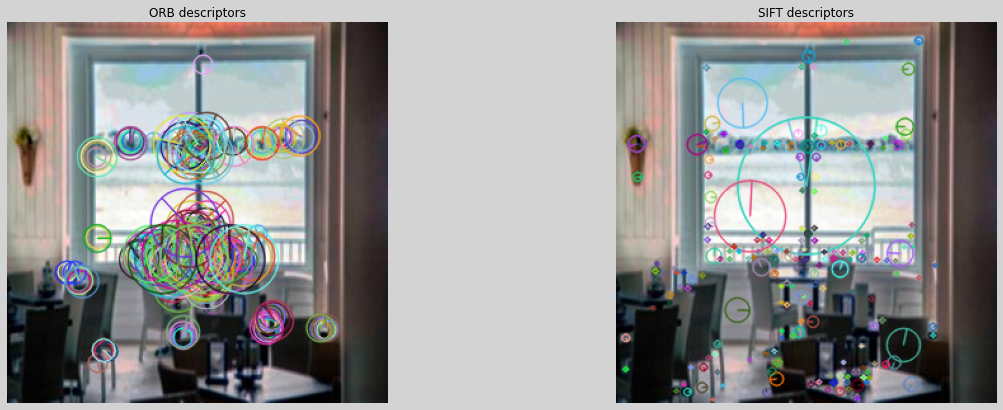

data/photos_preprocessed/RJufWmPFiAgKCKhf3jB-Pg.jpg DRINK


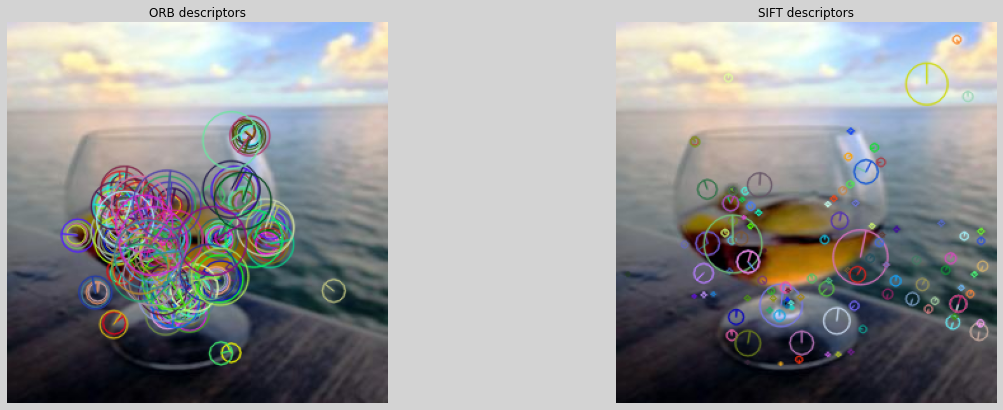

data/photos_preprocessed/MLILQeZOmN1klgyagfRE-A.jpg FOOD


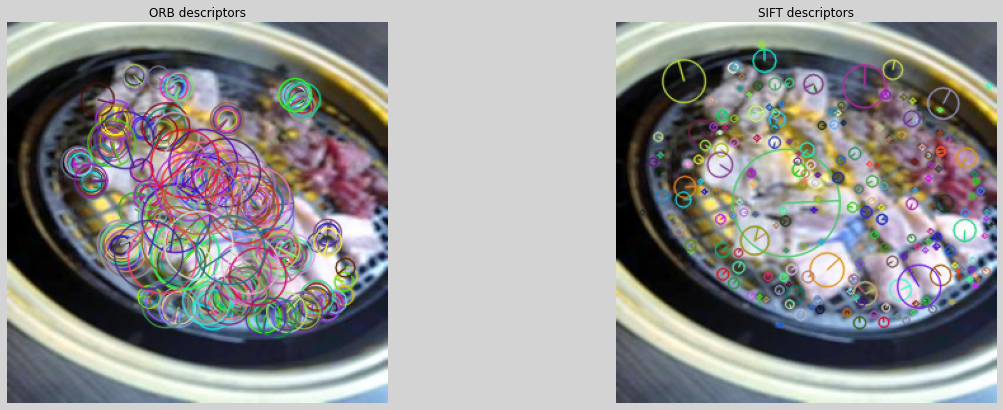

data/photos_preprocessed/k6x2IdfUX-Xphs2XEMz2uw.jpg MENU


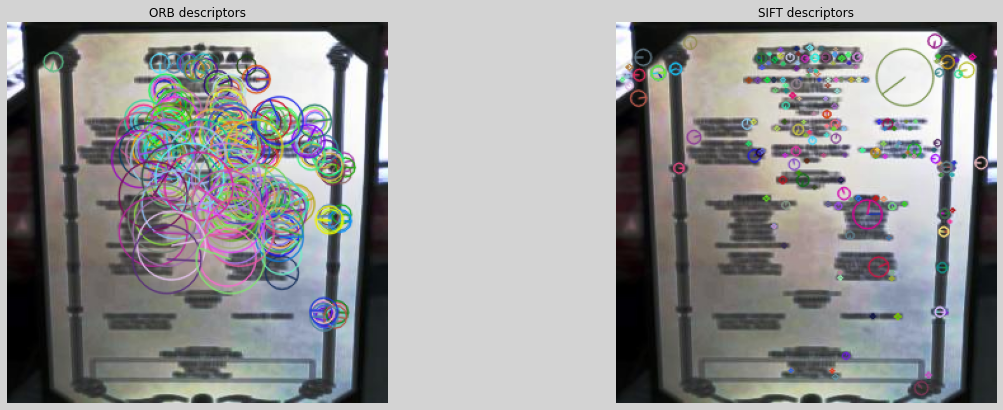

data/photos_preprocessed/0XrINgVTH3LtnhB5N9g-eA.jpg MENU


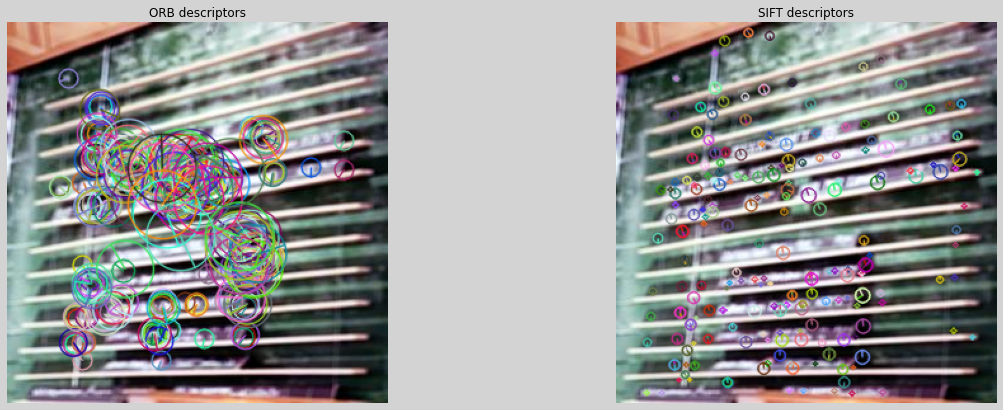

In [18]:
sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
des_list_SIFT=[]
des_list_ORB=[]

for i, photo in data_photos_selection.iterrows():
    img_path = pathlib.Path(preprocessed_path, f"{photo.photo_id}.jpg")
    img = Image.open(img_path)
    
    # Detect the keypoints and compute the descriptors
    mat = np.array(img)
    queryKeypointsORB, queryDescriptorsORB = orb.detectAndCompute(mat,None)
    queryKeypointsSIFT, queryDescriptorsSIFT = sift.detectAndCompute(mat,None)
    
    #des_list_ORB.append((i, queryKeypointsORB, queryDescriptorsORB))
    #des_list_SIFT.append((i, queryKeypointsSIFT, queryDescriptorsSIFT))
    des_list_ORB.extend(queryDescriptorsORB)
    des_list_SIFT.extend(queryDescriptorsSIFT)
    
    if photo.photo_id in sample_id_show:
        print(img_path, photo.label.upper())
        fig = plt.figure(figsize=(20,7), facecolor='lightgray')
        
        # draw only keypoints location,not size and orientation
        plt.subplot(1,2,1)
        plt.title("ORB descriptors")
        #img_orb = cv2.drawKeypoints(mat, queryKeypointsORB, None, color=(0,255,0), flags=0)
        img_orb = cv2.drawKeypoints(mat, queryKeypointsORB, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_orb)
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.title("SIFT descriptors")
        #img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, color=(0,255,0), flags=0)
        img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_sift)
        plt.axis('off')
        
        plt.show()

In [19]:
len(queryKeypointsORB), len(queryKeypointsSIFT)

(236, 250)

In [20]:
len(des_list_ORB), len(des_list_SIFT)

(246781, 244705)

In [21]:
len(des_list_ORB[0]), len(des_list_SIFT[0])

(32, 128)

#### Essais pour afficher les descriptors identifiés

ORB


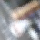

SIFT


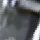

ORB in red, SIFT in yellow


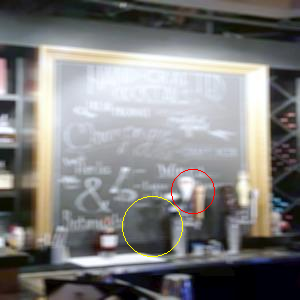

In [22]:
from PIL import ImageDraw 
import random

id = random.randint(0,min(len(queryKeypointsORB), len(queryKeypointsSIFT)))
(x_o, y_o) = queryKeypointsORB[id].pt
size_o = queryKeypointsORB[id].size
angle_o = queryKeypointsORB[id].angle
(x_s, y_s) = queryKeypointsSIFT[id].pt
size_s = queryKeypointsSIFT[id].size
angle_s = queryKeypointsSIFT[id].angle

left_s, left_o = x_s-size_s, x_o-size_o
right_s, right_o = x_s+size_s, x_o+size_o
top_s, top_o = y_s-size_s, y_o-size_o
bottom_s, bottom_o = y_s+size_s, y_o+size_o

# ORB Crop
img_copy = img.copy()
img_copy = img_copy.rotate(-angle_o, center=(x_o, y_o))
img_crop_o = img_copy.crop((left_o, top_o, right_o, bottom_o)).resize((40, 40), Image.Resampling.NEAREST)
print("ORB")
display(img_crop_o)

# SIFT Crop
img_copy = img.copy()
img_copy = img_copy.rotate(-angle_s, center=(x_s, y_s))
img_crop_s = img_copy.crop((left_s, top_s, right_s, bottom_s)).resize((40, 40), Image.Resampling.NEAREST)
print("SIFT")
display(img_crop_s)

# Show position
img_copy = img.copy()
draw = ImageDraw.Draw(img_copy)
draw.ellipse((left_o, top_o, right_o, bottom_o), fill = None, outline ='red')
draw.ellipse((left_s, top_s, right_s, bottom_s), fill = None, outline ='yellow')
print("ORB in red, SIFT in yellow")
display(img_copy)

## 2.2 Création du `dictionnaire de visual words` avec K-means ou un autre algorithme de clustering...

Les vecteurs générés durant l'étape d'extraction de features ci-dessus vont à présent être convertis en `visual words` *(qui sont aux images ce que les mots sont aux phrases)*. Les `visual words` ne sont rien d'autre que la représentation vectorielle de patches similaires et une fois rassemblés, produisent un **dictionnaire** similaire aux dictionnaires de mots pour les textes.

Cette étape est habituellement réalisée à l'aide d'un **k-means clustering**. 
- Chaque centre de cluster produit par *k-means* devient un *visual word*.
- Le nombre de clusters *k* correspond au nombre de *visual words* que l'on obtiendra au final.
- Le *dictionnaire de visual words* peut être appris sur des *training-sets* distincts.
- Si l'ensemble d'apprentissage est suffisamment représentatif, le livre de codes sera *universel*.
- Le *dictionnaire de visual words* est utilisé pour quantifier les features. La quantification des features signifie que le vecteur de la features est mis en correspondance avec l'index du *visual word* le plus proche dans un *dictionnaire de visual words*.

Pour résumer, chaque patches d'une image est associé à un *visual word* et l'image peut donc être représentée par l'histogramme des *visual words* *(certains revenant plus souvent que d'autres)*.

<img src="medias/bovw_create_dictionary.png" width="400">

In [25]:
from sklearn.cluster import KMeans

In [64]:
# num_clusters = data_photos.label.nunique()
num_clusters = 15
sample_size = 5000

In [65]:
X_training = pd.DataFrame(des_list_SIFT[:sample_size])

In [66]:
kmeans_SIFT = KMeans(random_state=random_seed, n_clusters=num_clusters).fit(X_training)

In [67]:
from sklearn.manifold import TSNE

def plot_TSNE(model_ref, X_ref, title='K-Means Clustering'):
    
    X_embedded = TSNE(n_components=2).fit_transform(X_ref)
    dataV=pd.DataFrame(X_embedded, columns=["D1","D2"])
    dataV['cluster']=model_ref.labels_.tolist()
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(dataV['D1'],dataV['D2'], c=dataV['cluster'], s=50, cmap=cmap_ref, marker='+')
    plt.colorbar(scatter)
    ax.set_title(title)
    ax.set_xlabel('Dimention 1')
    ax.set_ylabel('Dimention 2')
    plt.show()

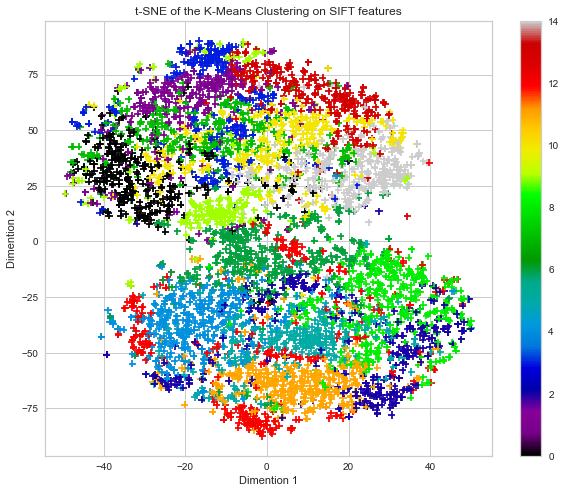

In [68]:
plot_TSNE(kmeans_SIFT, X_training, title="t-SNE of the K-Means Clustering on SIFT features")

#### Essayons de déterminer le nombre de visual-words idéal *k*

In [43]:
from yellowbrick.cluster import KElbowVisualizer

In [48]:
from tqdm import tqdm

2it [1:47:20, 3220.37s/it]


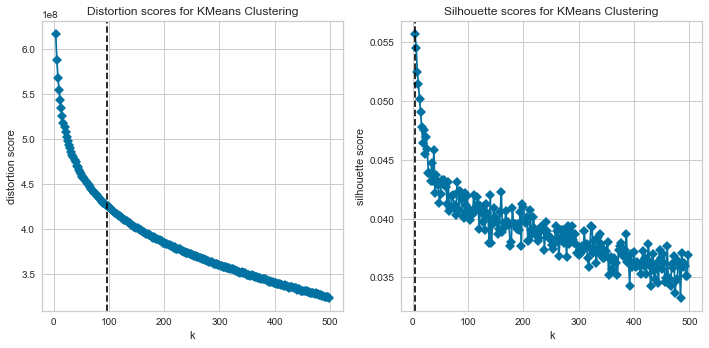

In [51]:
methods = ['distortion', 'silhouette'] #, 'calinski_harabasz']
kmeans = KMeans(random_state=random_seed)

fig = plt.figure(figsize=(15, 5))
for i, m in tqdm(enumerate(methods)):
    ax = plt.subplot(1, 3, i+1)
    visualizer = KElbowVisualizer(kmeans, k=range(4, 500, 2), metric=m, timings=False)
    visualizer.fit(X_training)
    plt.title(f"{m.title()} scores for KMeans Clustering")
    ax.set_ylabel(f'{m} score')
    ax.set_xlabel('k')
    #visualizer.show();

plt.tight_layout()
plt.show()

>#### Ce n'est pas très probant... et si l'on suit la recommandation il faudrait choisir environ 95 visual-words d'après le distrotion score ou 4 d'après le silhouette score.

#### Essayons de séparer notre dataset en 95 groupes

In [69]:
num_clusters = 95

In [70]:
kmeans_SIFT = KMeans(random_state=random_seed, n_clusters=num_clusters).fit(X_training)

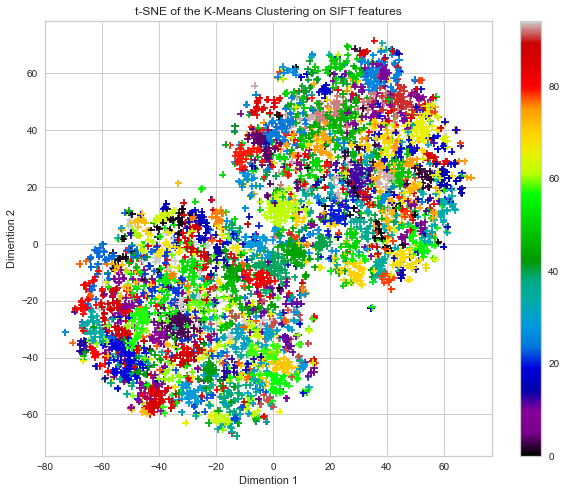

In [71]:
plot_TSNE(kmeans_SIFT, X_training, title="t-SNE of the K-Means Clustering on SIFT features")

>#### Il y a visiblement des regroupements de features, mais c'est assez difficile de les distinguer car il y a beaucoup de groupes

## 2.3 Construction des histogrammes ou `Bag of visual words`

#### Ajoutons une fonction pour créer une grille de features

In [320]:
from PIL import ImageFont
#font = ImageFont.truetype(10)

In [394]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    h_space, w_space = 10, 5
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*(w+w_space)-w_space, rows*(h+h_space)))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        sub_img = Image.new('RGB', size=(w, h+h_space))
        sub_img.paste(img, box=(0, h_space))
        draw = ImageDraw.Draw(sub_img)
        txt = f"{i+1}"
        ts = draw.textlength(txt)
        draw.text(((w-ts)/2,0),txt,(255,255,255), align='center')
        grid.paste(sub_img, box=(i%cols*(w+w_space), i//cols*(h+h_space)))
    return grid

data/photos_preprocessed/0XrINgVTH3LtnhB5N9g-eA.jpg OUTSIDE


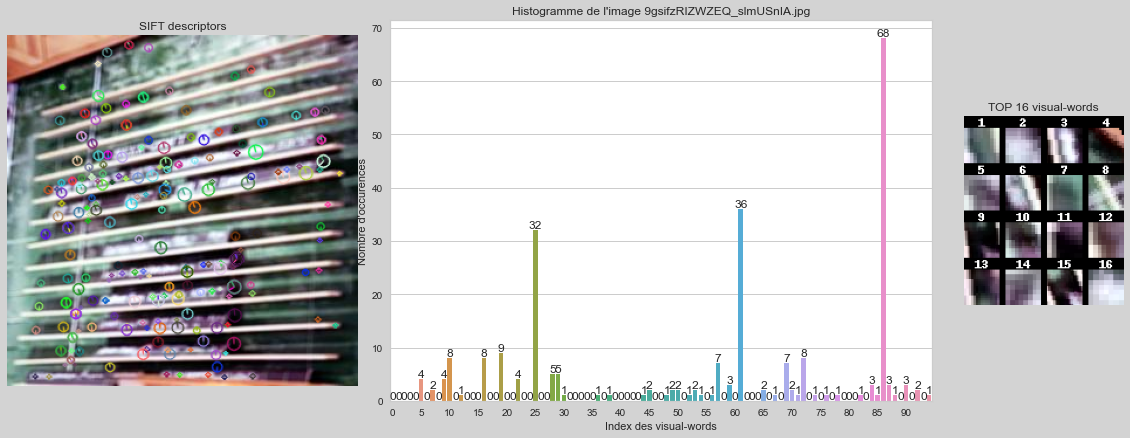

data/photos_preprocessed/k6x2IdfUX-Xphs2XEMz2uw.jpg OUTSIDE


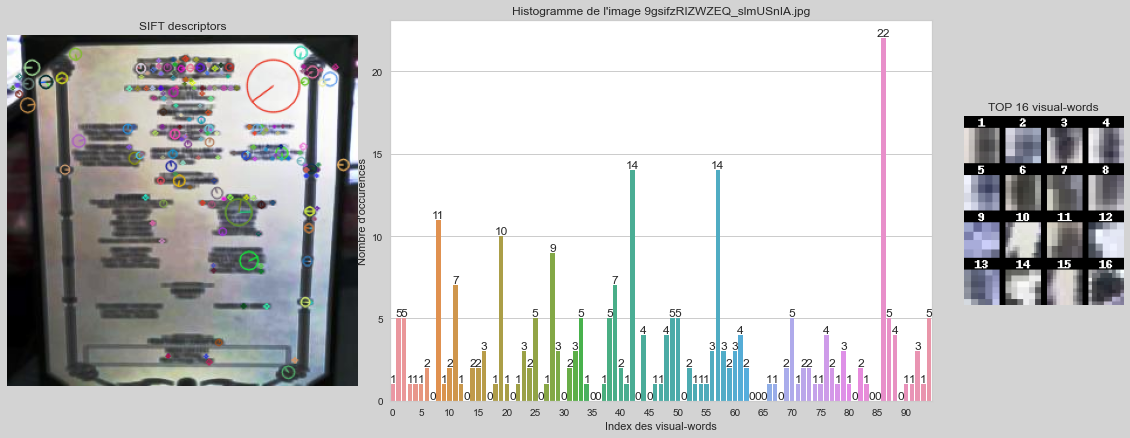

data/photos_preprocessed/9gsifzRIZWZEQ_slmUSnIA.jpg OUTSIDE


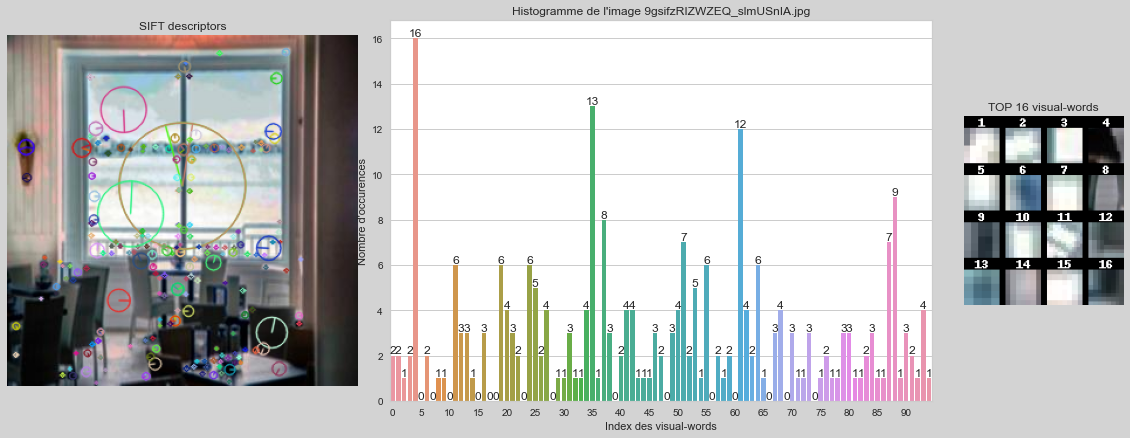

data/photos_preprocessed/RJufWmPFiAgKCKhf3jB-Pg.jpg OUTSIDE


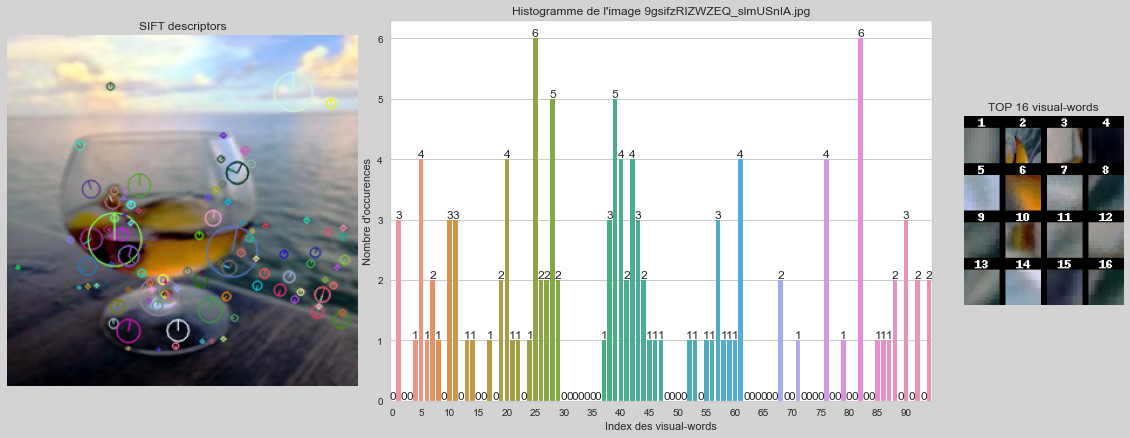

data/photos_preprocessed/MLILQeZOmN1klgyagfRE-A.jpg OUTSIDE


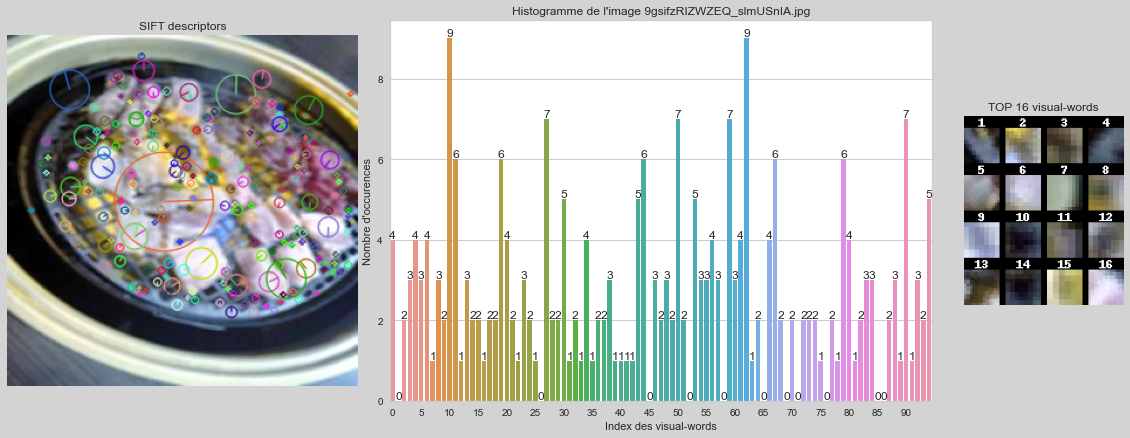

In [416]:
sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
root_num_top = 4

for photo_id in sample_id_show:
    
    fig = plt.figure(figsize=(20,7), facecolor='lightgray')
    
    img_path = pathlib.Path(preprocessed_path, f"{photo_id}.jpg")
    img = Image.open(img_path)
    
    # Detect the keypoints and compute the descriptors
    mat = np.array(img)
    #queryKeypointsORB, queryDescriptorsORB = orb.detectAndCompute(mat,None)
    queryKeypointsSIFT, queryDescriptorsSIFT = sift.detectAndCompute(mat,None)
    
    # Get visual-words for the histogramm
    preds = pd.DataFrame(kmeans_SIFT.predict(queryDescriptorsSIFT))
    select = pd.DataFrame(preds.value_counts(sort=False), columns=['count']).reset_index().rename(columns={0:'index'})
    select.set_index('index', inplace=True)
    select = select.reindex(list(range(0,select.index.max()+1)),fill_value=0)
    
    # print title
    print(img_path, photo.label.upper())
    
    select_top = select.sort_values('count', ascending=False)[:root_num_top**2]
        
    # draw only keypoints location,not size and orientation
    plt.subplot(1,6,(1,2))
    
    plt.title("SIFT descriptors")
    img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_sift)
    plt.axis('off')
        
    # draw visual-words histogram
    plt.subplot(1,6,(3,5))
    
    ax = sns.barplot(data=select.T)
    ax.bar_label(ax.containers[0])
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    labels_modulo=5
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=0)
    plt.ylabel("Nombre d'occurences")
    plt.xlabel("Index des visual-words")
    plt.title(f"Histogramme de l'image {photo.photo_id}.jpg")
    
    # draw visual-words
    grid_imgs = []
    for j in range(0,root_num_top**2):
        index = select_top.index[j]
        
        # Select one of the multiple patches as visual-word representation
        id = preds[preds.values == index].sample(1, random_state=random_seed).index[0]

        # Get the patch infos
        (x_s, y_s) = queryKeypointsSIFT[id].pt
        size_s = queryKeypointsSIFT[id].size
        angle_s = queryKeypointsSIFT[id].angle

        # SIFT Crop
        left_s = x_s-size_s
        right_s = x_s+size_s
        top_s = y_s-size_s
        bottom_s = y_s+size_s
        
        img_copy = img.copy().rotate(-angle_s, center=(x_s, y_s))
        img_crop_s = img_copy.crop((left_s, top_s, right_s, bottom_s)).resize((30,30), Image.Resampling.NEAREST)
        
        # Append to grid list
        grid_imgs.append(img_crop_s)
        
    plt.subplot(1,6,6)
    plt.title(f"TOP {root_num_top**2} visual-words")
    plt.imshow(image_grid(grid_imgs, rows=root_num_top, cols=root_num_top))
    plt.axis('off')
        
    plt.show()

## 2.4 Classification supervisée

C'est la dernière étape de notre méthode de résolution : l'objectif est d'apprendre les règles de décision permettant d'assigner correctement une représentation bag-of-features à une classe.

Cela signifie qu'on va entraîner un algorithme d'apprentissage supervisé sur les bag-of-features construits à l'étape 2.3. 

# 3. Création *automatique* des `bag of visual-words` avec un CNN pré-entrainé

Les réseaux de neurones convolutifs *(CNN)* ont une méthodologie similaire à celle des méthodes traditionnelles d'apprentissage supervisé : ils reçoivent des images en entrée, détectent les features de chacune d'entre elles, puis entraînent un classifieur dessus. Cependant, **les features sont apprises automatiquement et s'adaptent au problème donné !**

En effet, les CNN réalisent eux-mêmes tout le boulot fastidieux d'extraction et description de features : lors de la phase d'entraînement l'erreur de classification est minimisée afin d'optimiser les paramètres du classifieur ET les features ! De plus, l'architecture spécifique du réseau permet d'extraire des features de différentes complexités, des plus simples au plus sophistiquées.

- `Couche de Convolution`: consiste à repérer la présence d'un ensemble de features dans les images reçues en entrée.
- `Couche de Pooling`: consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.
- `Couche de correction ReLU`: remplace donc toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation.
- `Couche fully-connected`: constitue toujours la dernière couche d'un réseau de neurones *(convolutif ou non)*. La dernière couche fully-connected permet de classifier l'image en entrée du réseau parmi les N catégories possibles.

Pour calculer les probabilités, la couche `fully-connected` multiplie chaque élément en entrée *(issus de la couche de correction ReLU)* par un poids, fait la somme, puis applique une fonction d'activation *(logistique si N=2, softmax si N>2)*


In [ ]:
X = pd.DataFrame(queryDescriptorsORB)

In [ ]:
kmeans_ORB = KMeans(random_state=random_seed, n_clusters=num_clusters).fit(X)

In [ ]:
get_clustering_scores("Kmeans [basic]",  model=kmeans_ORB, X_ref=X, register=True)

In [ ]:
plot_TSNE(kmeans_ORB, X, title="t-SNE of the K-Means Clustering on ORB features")

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(queryDescriptorsSIFT[100].reshape(4,32), cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
len(queryDescriptorsSIFT[0])